# 1. Setup

## 1.1 initialize - load packages and define params

In [1]:
import toytree, toyplot, re, copy, itertools
import toyplot.pdf
import numpy as np
from numpy import random
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ALL_COLORS = ["rgba(33,146,164,1)", #2192a4
                "rgba(0,3,128,1)",  #000380
                "rgba(239,133,91,1)", #ef855b
                "rgba(50%,50%,50%,1)"]

ALL_COLORS_HEX = ['#2192a4','#000380','#ef855b']

ALL_COLORS_SCALED = [(0.1294,0.5725,0.6431),
                     (0,0.0118,0.5020),
                     (0.9373,0.5216,0.3569)]

all_patients = ['P13','P14','P09','P42','P01','P46','P10']
all_patient_labels = ['B','C','D','*F','*G','*H','*I']


## 1.2 helper functions for phylogeny objects

In [2]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def get_tree(tfile): 
    with open(tfile,'r') as tfile: 
        tree = tfile.read().replace('\n','')
    return tree

def get_unique_sample_strings(treestr): 
    namebit = '\w+(?=\-)'
    matches = re.findall(namebit, treestr)
    samples = list(set(matches))
    samples = natural_sort(samples)
    colordict = dict(zip(samples,ALL_COLORS[0:len(samples)]))
    return samples, colordict

def get_tip_colors(colordict,treeobj):
    colorlist = [colordict[t[0:t.find('-')]] if t.find('-') is not -1 else \
                 "black" for t in treeobj.get_tip_labels()]
    return colorlist

def get_node_colors(colordict,treeobj): 
    colorlist = [colordict[t[0:t.find('-')]] if t.find('-') is not -1 else \
                 "white" for t in treeobj.get_node_dict().values()]
    return colorlist

def get_leaves_rename_dict(): 
    samplenamedict = {'05SP1A':'A1',
                         '45SP1':'E1', 
                         '13SP1':'B1',
                         '13SP3':'B4',
                         '42SP1':'F0',
                         '42SP2':'F5',
                         '42ST1':'F6',
                         '14SP1':'C0',
                         '14SP3':'C10',
                         '46SP1B':'G0',
                         '46SP3':'G10',
                         '09SP1':'D0',
                         '09SP4':'D11',
                         '09ST1':'D5',
                         '10SP1b':'H0',
                         '10SP4b':'H11',
                         '01SP9':'I39',
                         '01SP10':'I50'} 
    return samplenamedict

def rename_tree_leaves(tobj): 
    t_renamed = copy.deepcopy(tobj)
    samplenamedict = get_leaves_rename_dict() 
    namebit = '\w+(?=\-)'
    for leaf in t_renamed.treenode.iter_leaves():
        if '-' in leaf.name: 
            leaf_sample = re.findall(namebit, leaf.name)
            newname = samplenamedict[leaf_sample[0]]
            newname_isol0 = re.sub(leaf_sample[0],'',leaf.name) # remove first part of isolate name
            newname_isol = re.sub('-','',newname_isol0) # remove first part of isolate name
            leaf.name = newname_isol
    return t_renamed

def move_outgroup_to_bottom(treeh): 
    outgroup_idx = treeh.get_tip_labels().index('Outgroup')
    all_coords = treeh.get_tip_coordinates()
    new_coords = all_coords.copy()

    # move index of all leaves up by one along y-coord
    for i in range(0,outgroup_idx):
        cur_coord = all_coords[i]
        new_coord = [cur_coord[0], cur_coord[1]+1]
        new_coords[i] = new_coord

    new_coords[outgroup_idx,1] = 0

    for idx, coords in zip(range(len(new_coords)),new_coords): 
        treeh.get_tip_coordinates()[idx] = coords
    return treeh, new_coords

## 1.3 helper functions for plotting

In [3]:
def get_plot_attr(patient):
    patient_plot_width = {'P13':150, 
                          'P14':125, 
                          'P42':170,
                          'P10':400,
                          'P46':200,
                          'P45':150,
                         'P09':150,
                         'P01':180,
                         'P05':140}
    patient_plot_height = {'P45':200, 
                           'P13':500,
                          'P14':500, 
                          'P42':500,
                          'P10':500,
                         'P46':500,
                          'P45':300,
                         'P09':500,
                         'P01':400,
                         'P05':250}
    patient_tip_font = {'P13':"8px",
                        'P14':"9px",
                        'P45':"8px", 
                       'P42':"7px",
                       'P10':"8px",
                       'P46':"7px",
                       "P09":"6px",
                       'P01':"6px",
                       'P05':"6px"} 
    try: 
        wid = patient_plot_width[patient]
        hgt = patient_plot_height[patient]
        fsize = patient_tip_font[patient]
    except KeyError: 
        wid = 400
        hgt = 500
        fsize = "9px"
    return wid, hgt, fsize

def get_sample_hbar_rename_dict(): 
    samplenamedict = {'05SP1A':'Day 1',
                         '45SP1':'Day 1', 
                         '13SP1':'Day 1',
                         '13SP3':'Day 5',
                         '42SP1':'Day 1',
                         '42SP2':'Day 6',
                         '42ST1':'Day 7',
                         '14SP1':'Day 1',
                         '14SP3':'Day 11',
                         '46SP1B':'Day 1',
                         '46SP3':'Day 11',
                         '09SP1':'Day 1',
                         '09SP4':'Day 12',
                         '09ST1':'Day 6',
                         '10SP1b':'Day 1',
                         '10SP4b':'Day 12',
                         '01SP9':'Day 1',
                         '01SP10':'Day 12'} 
    return samplenamedict

def get_barplot_size(pat,plottype): 
    pat_vplot = {'P10':(1.5,2),
               'P13':(1.5,2)}
    pat_hplot = {'P10':(4,3),
                'P13':(1.5,2), 
                'P14':(1.5,2), 
                'P46':(4,3),
                'P42':(2,3)}
    if plottype == 'vertical': 
        try: 
            figsize = pat_vplot[pat]
        except KeyError: 
            figsize = (3,6)
    elif plottype == 'horizontal': 
        try: 
            figsize = pat_hplot[pat]
        except KeyError: 
            figsize = (6,4)
    return figsize
    
def plot_hbar(obs,samplestr,pat): 
    xtickrange = {'P10':np.arange(0,20,5),
                  'P09':np.arange(0,0.2,0.1),
                  'P14':np.arange(0,2,1),
                 'P01':np.arange(0,5,1),
                 'P13':np.arange(0,2,1),
                 'P42':np.arange(0,1,0.5),
                 'P46':np.arange(0,9,3)}
    xtickpat = xtickrange[pat]
  
    # fetch renamed sample names 
    sample_rename_dict = get_sample_hbar_rename_dict()
    sample_rename = [sample_rename_dict[s] for s in samplestr]
    
    psize = get_barplot_size(pat,'horizontal')
    
    fig = plt.figure(figsize=psize, dpi=300)
    xval=np.flipud(np.arange(len(obs)))
    barlist=plt.barh(xval,obs,0.5,align='center',alpha=0.8)
    plt.ylim((-0.5,1.5))
    plt.xlim((0,1.5))
    for o in range(len(obs)): 
        barlist[o].set_color(ALL_COLORS_SCALED[o])
    axis_font = {'fontname':'Arial', 'size':'20'}
    plt.xticks(xtickpat,xtickpat,**axis_font)
    plt.yticks(xval,sample_rename,**axis_font)
    plt.rcParams['xtick.labelsize'] = 10 
    plt.xlabel(r'$<d_{MRCA}> $',**axis_font)
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def plot_phylogeny(patient):
    tfile = 'patient_trees/%s_singleSNP.tree' %(patient)
    newick = get_tree(tfile)
    treeh = toytree.tree(newick)
    treeh.ladderize()
    treeh.root("Outgroup") 
    treeh.rotate_node(names='Outgroup')

    samplestr, samplecolors = get_unique_sample_strings(newick)
    tipcolors = get_tip_colors(samplecolors, treeh)
    reversedtipcolors = tipcolors
    nodecolors = get_node_colors(samplecolors,treeh)

    nls = ["" if node not in treeh.get_tip_labels() else node 
           for node in treeh.get_node_dict().values()]

    tree_renamed_temp = rename_tree_leaves(treeh) 
    tree_renamed, new_coords = move_outgroup_to_bottom(tree_renamed_temp)

    plot_width, plot_height, tip_font_size = get_plot_attr(patient)
    figout, axes = tree_renamed.draw(
                    width=plot_width, height=plot_height, 
                    use_edge_lengths=True, 
                    tip_labels_align=False,
                    tip_labels_colors=reversedtipcolors,
                    tip_labels=True, 
                    tip_labels_style={                                                                                                                                                                                      
                        "font-size":tip_font_size,
                        "font-weight":"bold",
                        "-toyplot-anchor-shift": "3px"
                        },
                    node_labels=False, 
                    node_sizes=0,
                    node_labels_style={
                                        "baseline-shift": "15px", 
                                        "-toyplot-anchor-shift": "15px",
                                        "font-size": "10px"}, 
                    edge_style={"stroke-width":1}
                    )
    return treeh, samplestr

# toyplot.pdf.render(figout, outfilename)

# 2. Plot phylogeny of each patient's population

In [5]:
patient = 'P10'
tree_handle, patient_samples = plot_phylogeny(patient)

3 5 13 16 17 18 19 22 24 3 2 15 1 6 8 9 10 11 12 14 20 21 23 6 8 9 23 1 2 4 5 7 10 12 13 14 15 17 18 19 20 21 22 24 7 4 11 16 Outgroup

# 3. plot < d_MRCA > for each sample, e.g. Fig. 3c

Observed difference in <d_MRCA,t2> and <d_MRCA,t1>: 7.708
Empirical p-value across 1000 simulations: 0.000


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


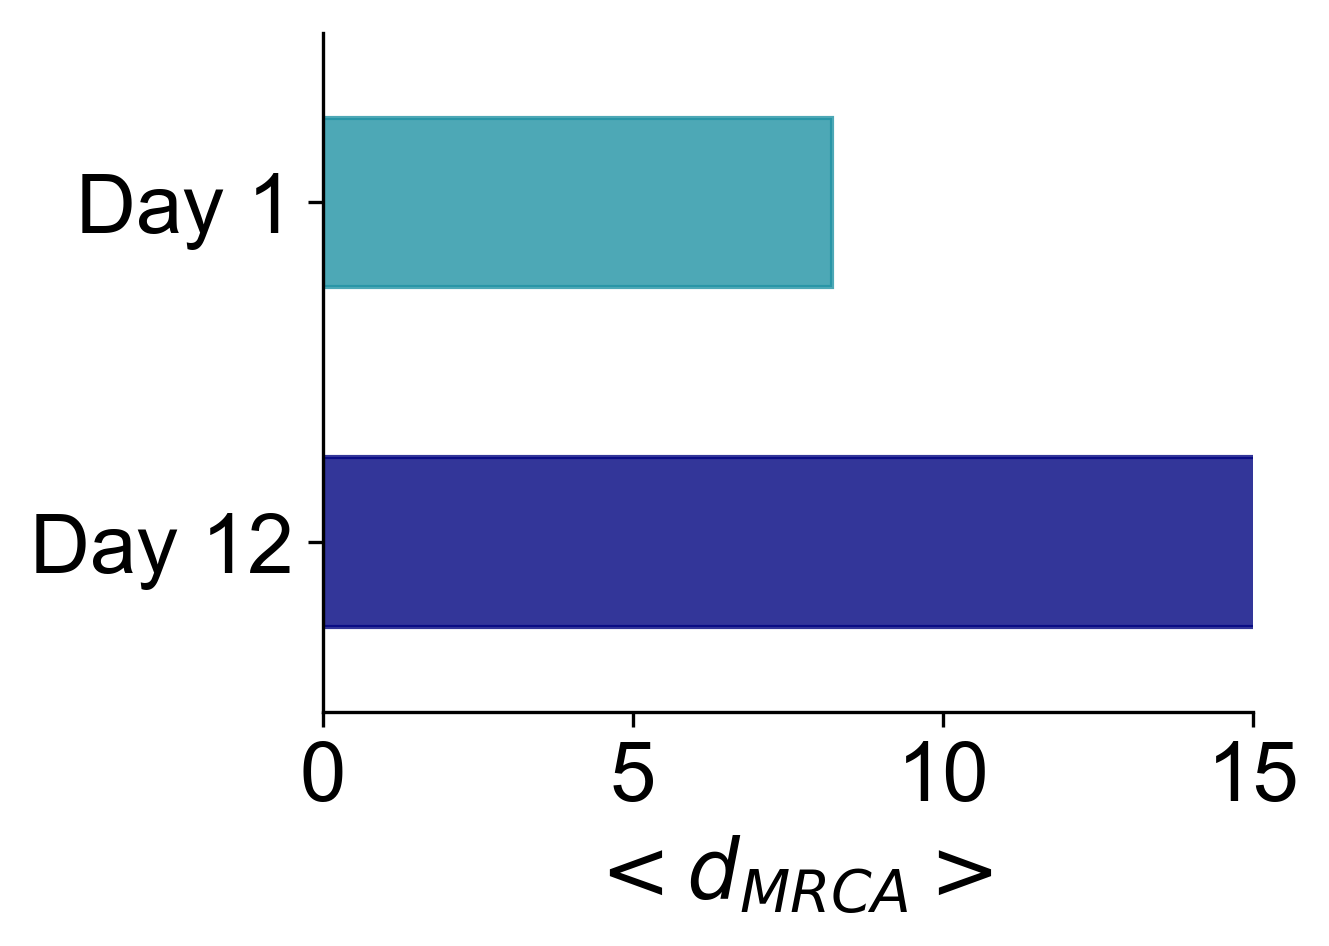

In [6]:
def get_root_to_tip_dists(tobj,samplestr,leaf_to_sample):
    distances = {key: [] for key in samplestr}
    for leaf in tobj.get_tip_labels():
        dist = tobj.treenode.get_distance(leaf)
        if leaf in leaf_to_sample: 
            distances[leaf_to_sample[leaf]].append(dist) 
    mean_distances = []
    std_distances = []
    for sample in samplestr: 
        dist_mean = np.mean(distances[sample])
        mean_distances.append(dist_mean)
        std_distances.append(np.std(distances[sample]))
    return mean_distances, distances, std_distances

def get_leafname_to_sample(tobj,permute=False): 
    namebit = '[0-9]+SP\w+(?=\-)'
    leaves = tobj.get_tip_labels()
    leaf_sample = {}
    for leaf in leaves:
        matches = re.findall(namebit, leaf)
        if len(matches) == 1: 
            lsample = matches[0]
            leaf_sample[leaf] = lsample
    if permute: 
        orig_keys = list(leaf_sample.keys())
        keys = random.permutation(orig_keys)
        leaf_sample = dict(zip(keys, leaf_sample.values()))
    return leaf_sample

def get_pvalues(tobj,samplestr,numtrials=1000):
    # calculate the difference of <d_MRCA> between time point 1 and time point 2
    leafsamples_obs = get_leafname_to_sample(tobj, permute=False)
    obs_vals, dists_obs, obs_vals_std = get_root_to_tip_dists(tobj,samplestr,leafsamples_obs)
    obs_diff = obs_vals[1]-obs_vals[0]

    i = 0
    null_vals = [] 
    while i<numtrials: 
        leafsamples_null_i = get_leafname_to_sample(tobj, permute=True)
        null_i, dists_null_i, null_i_std = get_root_to_tip_dists(tobj, samplestr, leafsamples_null_i)
        null_diff = null_i[1]-null_i[0]
        null_vals.append(null_diff)
        i+=1

    pval_s = float(sum(obs_diff>null_vals))/numtrials
    print('Observed difference in <d_MRCA,t2> and <d_MRCA,t1>: %0.3f' %obs_diff)
    print('Empirical p-value across %i simulations: %0.3f' %(numtrials, 1-pval_s) )
    
    return obs_vals, obs_vals_std, obs_diff, null_vals

obs_means, obs_stds, obs_diff, null_diffs = get_pvalues(tree_handle, patient_samples)
plot_hbar(obs_means, patient_samples, patient)

# 4. plot distribution of d_MRCA, e.g. Fig. 3a

P13
P14
P09
P42
P01
P46
P10


/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

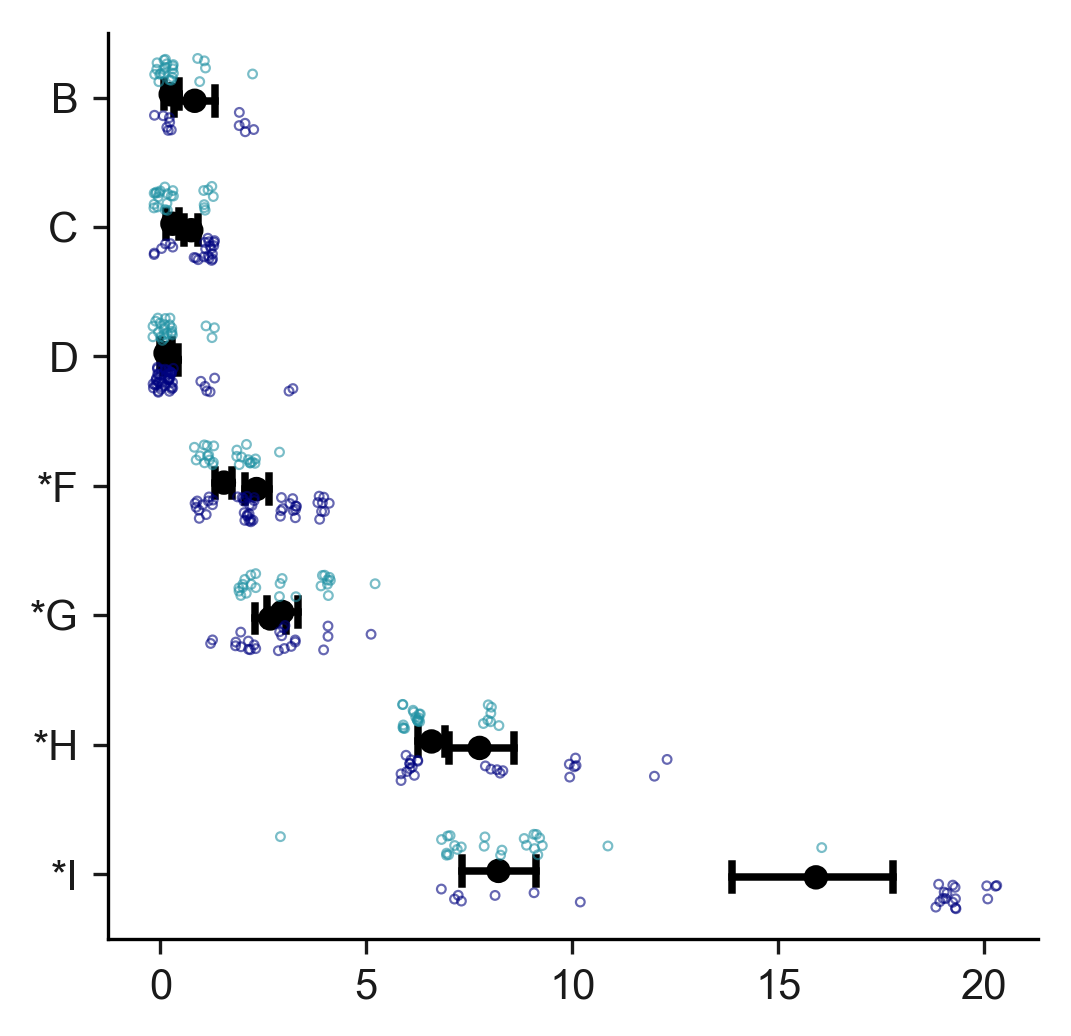

In [6]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def get_leaf_to_sample(tobj):
    namebit = '\w+(?=\-)'
    leaves = tobj.get_tip_labels()
    leaf_sample = {}
    for leaf in leaves: 
        matches = re.findall(namebit, leaf)
        if len(matches) == 1: 
            lsample = matches[0]
            leaf_sample[leaf] = lsample
    return leaf_sample

def get_root_to_tip_dists_all(tobj,samplestr):
    distances = {key: [] for key in samplestr}
    leaf_to_sample = get_leaf_to_sample(tobj)
    for leaf in tobj.get_tip_labels():
        dist = tobj.treenode.get_distance(leaf)
        if leaf in leaf_to_sample:
            try: 
                distances[leaf_to_sample[leaf]].append(dist) 
            except KeyError: 
                continue
    mean_distances = []
    std_distances = []
    for sample in samplestr: 
        dist_mean = np.mean(distances[sample])
        mean_distances.append(dist_mean)
        std_distances.append(np.std(distances[sample]))
    return mean_distances, distances, std_distances

def get_sample_times(samplestr):
    sampletimedict = {'05SP1A':0,
                         '45SP1':0, 
                         '13SP1':0,
                         '13SP3':4,
                         '42SP1':0,
                         '42SP2':5,
                         '42ST1':6,
                         '14SP1':0,
                         '14SP3':10,
                         '46SP1B':0,
                         '46SP3':10,
                         '09SP1':0,
                         '09SP4':11,
                         '09ST1':5,
                         '10SP1b':0,
                         '10SP4b':11,
                         '01SP9':0,
                         '01SP10':11} 
    stimes = [sampletimedict[s] for s in samplestr]
    return stimes

def get_dataframe(patients): 
    df_temp = {'dists':[],'time':[],'sampletype':[],'patient':[],'sampleorder':[]}
    for patient,pidx in zip(patients,range(len(patients))): 
        print(patient)
        
        # load tree
        tfile = 'patient_trees/%s_singleSNP.tree' %(patient)
        newick = get_tree(tfile)
        samplestr, samplecolors = get_unique_sample_strings(newick)
        treeh = toytree.tree(newick) 
        treeh.root("Outgroup")
        
        # get patient's d_MRCAs
        obs_vals, dists_obs, obs_vals_std = get_root_to_tip_dists_all(treeh,samplestr)
        sample_days = get_sample_times(samplestr)
        for sample, si in zip(samplestr,range(len(samplestr))):
            cur_sample_ct = len(dists_obs[samplestr[si]])
            xval = np.tile(sample_days[si],cur_sample_ct)
            yval = dists_obs[samplestr[si]]            
            df_temp['dists'].extend(yval)
            df_temp['time'].extend(xval)
            df_temp['patient'].extend(np.tile(patient,cur_sample_ct))
            if 'SP' in samplestr[si]:
                df_temp['sampletype'].extend(np.tile('SP',cur_sample_ct))
            elif 'ST' in samplestr[si]: 
                df_temp['sampletype'].extend(np.tile('ST',cur_sample_ct))

            if sample_days[si]==0: 
                df_temp['sampleorder'].extend(np.tile(0,cur_sample_ct))
            else: 
                df_temp['sampleorder'].extend(np.tile(1,cur_sample_ct))
            
    df = pd.DataFrame(data=df_temp)
    return df

# --- Make dataframe with all d_MRCAs --- #

all_df = get_dataframe(all_patients)
all_df = all_df.replace(all_patients, all_patient_labels)

plt.clf()
plt.figure(num=None,figsize=(4,4),dpi=300,facecolor='none',edgecolor='none')
ax = plt.axes()

# add jitter
a = -1
b = 1
dist_jitter = (b-a)*np.random.random(len(all_df.dists))+a
jitter_scale = 4
all_df['dists_jitter'] = all_df.dists+dist_jitter/jitter_scale

# plot
params = dict(x='dists_jitter',
              y='patient',
             hue='sampleorder',
             size=4,
              split=True,
              edgecolor='none')

plt.setp(ax.collections, alpha=0.7)

sns.stripplot(data=all_df, palette=ALL_COLORS_HEX[0:2],**params,jitter=0.2,
              alpha=0.6, marker='$\circ$')

sns.set_context(rc = {'patch.linewidth': 0.2, 'lines.linewidth':1})
sns.pointplot(x='dists',y='patient',hue='sampleorder',dodge=True,
                 data=all_df, palette={0:'#000000',1:'#000000'},join=False, 
                  linewidth=0.2, capsize=.2, scale=1, alpha=0.7)

sns.despine()
ax.legend_ = None
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.set(style='ticks', context='talk')
axis_font = {'fontname':'Arial', 'size':'14'}
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.ylabel('',**axis_font)
plt.xlabel('',**axis_font)
plt.show()